In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
previous_file_idx = -1
TOTAL_NUM_DAYS = len(daydic)

In [3]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    
    def within_search_width(i_offset, j_offset):
        return distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                        lat_rho[i_search + i_offset, j_search + j_offset], 
                        lon_rho[i_search + i_offset, j_search + j_offset]) < SEARCH_WIDTH / 2

    i_left, i_right = 0, 0
    j_down, j_up = 0, 0

    while i_search - i_left >= 0 and within_search_width(-i_left, 0):
        i_left += 1
    while i_search + i_right < lon_rho.shape[0] and within_search_width(i_right, 0):
        i_right += 1
    while j_search - j_down >= 0 and within_search_width(0, -j_down):
        j_down += 1
    while j_search + j_up < lon_rho.shape[1] and within_search_width(0, j_up):
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_down = max(j_search - j_down + 1, 0)
    j_up = min(j_search + j_up, lon_rho.shape[1])

    return i_left, i_right, j_down, j_up

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def find_global_maxima(matrix):
    i_max, j_max = np.unravel_index(np.argmax(matrix, axis=None), matrix.shape)
    return i_max, j_max

def find_local_maxima(matrix):
    def is_local_maxima(matrix, i, j):
        rows, cols = matrix.shape
        value = matrix[i, j]
        if np.isnan(value):
            return False
        def is_valid_and_greater_than(value, neighbor):
            return not np.isnan(neighbor) and neighbor > value
        if i > 0 and is_valid_and_greater_than(value, matrix[i - 1, j]):
            return False
        if i < rows - 1 and is_valid_and_greater_than(value, matrix[i + 1, j]):
            return False
        if j > 0 and is_valid_and_greater_than(value, matrix[i, j - 1]):
            return False
        if j < cols - 1 and is_valid_and_greater_than(value, matrix[i, j + 1]):
            return False
        if i > 0 and j > 0 and is_valid_and_greater_than(value, matrix[i - 1, j - 1]):
            return False
        if i > 0 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i - 1, j + 1]):
            return False
        if i < rows - 1 and j > 0 and is_valid_and_greater_than(value, matrix[i + 1, j - 1]):
            return False
        if i < rows - 1 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i + 1, j + 1]):
            return False
        return True
    i_max, j_max, value_max = [], [], []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if is_local_maxima(matrix, i, j):
                i_max.append(i)
                j_max.append(j)
                value_max.append(matrix[i, j])
    return i_max, j_max, value_max

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def get_variable_name(var):
    for name, value in globals().items():
        if value is var:
            return name
    return None

def make_cartesian(lon, lat, theta0, phi0):
    lonr = np.deg2rad(lon)
    latr = np.deg2rad(lat)
    r_earth = 6371
    x = r_earth * np.cos(phi0) * (lonr - theta0)
    y = r_earth * (latr - phi0)
    return x, y

def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x/1000, y/1000

def rotate_30_clockwise(x, y):
    theta = np.deg2rad(30)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated, y_rotated

def extract_contour(level_to_extract, plot):
    for level_paths in plot.allsegs:
        for path in level_paths:
            xt = path[:, 0]
            yt = path[:, 1]
            return xt, yt
    else:
        return [], []

### Load Eddy Data

In [4]:
edata = eddies['Eddy19'].iloc[40] #E22T5 #E17T3 #9T10 #E19T40
t = extract_number(edata.name)

mcolor = 'r' if edata.Vort > 0 else 'c'
colormap = 'Reds' if edata.Vort > 0 else 'Blues'

temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

t_mod = t % 30
file_idx = np.floor(t/30)
if file_idx != previous_file_idx:

    fnumber = '0'+str(round(1461+ file_idx*30))
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_'+fnumber+'.nc'
    dataset = nc.Dataset(fname)

    U = np.load('/srv/scratch/z5297792/Climatology/u_v/u_'+fnumber+'.npy')
    V = np.load('/srv/scratch/z5297792/Climatology/u_v/v_'+fnumber+'.npy')
    Vorticity = np.load('/srv/scratch/z5297792/Climatology/vorts/vort_'+fnumber+'.npy')
    TemperatureAnomaly = np.load('/srv/scratch/z5297792/Climatology/temps/temp_'+fnumber+'.npy') - np.repeat(temp_ave[:, :, :, np.newaxis], 30, axis=3)
    CurSpeed = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/cur_speed_'+fnumber+'.npy')
    CurSpeedAnomaly = CurSpeed - np.repeat(CurSpeed_ave[:, :, :, np.newaxis], 30, axis=3)
    OW = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/ow_'+fnumber+'.npy')
    ocean_time = dataset.variables['ocean_time'][:]

    previous_file_idx = file_idx

In [5]:
SEARCH_RADIUS = 50000
DEPTH_LVL_LIMIT = 25

DataField1 = OW

DataField1_name = get_variable_name(DataField1)
DataField1 = np.squeeze(DataField1[:, :, :, t_mod])

depth_dics1 = {}

clon, clat = edata.Lon, edata.Lat
theta0, phi0 = np.deg2rad(edata.Lon), np.deg2rad(edata.Lat)
for depth_lvl in range(DEPTH_LVL_LIMIT):

    i_search_lvl, j_search_lvl = eddies_nearest_rho(clon, clat)
    R = distance(lat_rho[i_search_lvl, j_search_lvl], lon_rho[i_search_lvl, j_search_lvl], lat_rho, lon_rho)
    mask = R < SEARCH_RADIUS
    
    DataField1_masked = np.where(mask, DataField1[:,:,depth_lvl], np.nan)
    if np.any(np.isfinite(DataField1_masked)):
        if DataField1_name == 'CurSpeed' or 'OW':
            ic, jc = np.unravel_index(np.nanargmin(DataField1_masked), DataField1_masked.shape)
        else:
            if edata.Vort > 0:
                ic, jc = np.unravel_index(np.nanargmax(DataField1_masked), DataField1_masked.shape)
            elif edata.Vort < 0:
                ic, jc = np.unravel_index(np.nanargmin(DataField1_masked), DataField1_masked.shape)
        ic, jc = int(ic), int(jc)

        ix, jy = np.where(mask == True)

        lons, lats = lon_rho[ix, jy], lat_rho[ix, jy]
        lonc, latc = lon_rho[ic, jc], lat_rho[ic, jc]
        
        x, y = make_cartesian(lons, lats, theta0, phi0)
        xc, yc = make_cartesian(lonc, latc, theta0, phi0)
            
        df = pd.DataFrame({
            'i': ix,
            'j': jy,
            'DataField': DataField1_masked[ix,jy],
            'x': x,
            'y': y
        })
    
        depth = float(z_r[150,150,depth_lvl])
    
        depth_dics1['Depth'+str(depth_lvl)] = {'df': df, 'ic': ic, 'jc': jc, 'xc': xc, 'yc':yc, 'Depth': depth}
    
        clon, clat = lon_rho[ic, jc], lat_rho[ic, jc]

# Calculate Cartesian Grid
theta0, phi0 = np.deg2rad(edata.Lon), np.deg2rad(edata.Lat)
for depth_dic in depth_dics1.values():
    
    ix = depth_dic['df'].i
    jy = depth_dic['df'].j
    ic = depth_dic['ic']
    jc = depth_dic['jc']
    
    lons, lats = lon_rho[ix, jy], lat_rho[ix, jy]
    lonc, latc = lon_rho[ic, jc], lat_rho[ic, jc]

    x, y = make_cartesian(lons, lats, theta0, phi0)
    xc, yc = make_cartesian(lonc, latc, theta0, phi0)

    depth_dic['df']['x'] = x
    depth_dic['df']['y'] = y
    depth_dic['xc'] = float(xc)
    depth_dic['yc'] = float(yc)

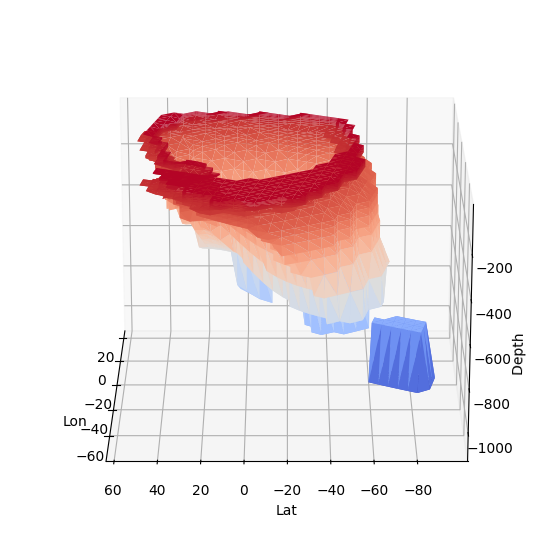

In [6]:
LOW_3D = np.full((lon_rho.shape[0], lon_rho.shape[1], DEPTH_LVL_LIMIT), np.nan)

for depth_lvl in range(DEPTH_LVL_LIMIT):
    depth_dic = depth_dics1['Depth'+str(depth_lvl)]
    i, j = depth_dic['df'].i, depth_dic['df'].j

    LOW_3D[i, j, depth_lvl] = depth_dic['df'].DataField

LOW_3D = np.where(~np.isnan(LOW_3D), LOW_3D, 0)
OW_range = np.linspace(0, LOW_3D.min(),10)

from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

# Assuming LOW_3D is already populated as per your code
isosurface_value = OW_range[1]

# Find the isosurface using marching cubes
verts, faces, _, _ = measure.marching_cubes(LOW_3D, level=isosurface_value, allow_degenerate=False)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Convert `verts` indices to `lon_rho`, `lat_rho`, and depth `z_r`
lon_vals = lon_rho[verts[:, 0].astype(int), verts[:, 1].astype(int)]
lat_vals = lat_rho[verts[:, 0].astype(int), verts[:, 1].astype(int)]

theta0, phi0 = np.deg2rad(edata.Lon), np.deg2rad(edata.Lat)
x, y = make_cartesian(lon_vals, lat_vals, theta0, phi0)

z_vals = z_r[verts[:, 0].astype(int), verts[:, 1].astype(int), verts[:, 2].astype(int)]

# Plot the isosurface
ax.plot_trisurf(x, y, faces, z_vals, cmap='coolwarm', lw=1)

# Set labels
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_zlabel('Depth ')

ax.view_init(elev=20, azim=180)

# Show the plot
plt.show()

In [7]:
def compute_volume(verts, faces, lon_rho, lat_rho, z_r):
    total_volume = 0

    # Loop through each face (triangle)
    for face in faces:
        v0, v1, v2 = verts[face].astype(int)
        
        # Get corresponding points in lon, lat, and depth
        x0, y0, z0 = lon_rho[v0[0], v0[1]], lat_rho[v0[0], v0[1]], z_r[v0[2]]
        x1, y1, z1 = lon_rho[v1[0], v1[1]], lat_rho[v1[0], v1[1]], z_r[v1[2]]
        x2, y2, z2 = lon_rho[v2[0], v2[1]], lat_rho[v2[0], v2[1]], z_r[v2[2]]
        
        # Define vectors for the face vertices relative to the origin or centroid
        vec1 = np.array([x1 - x0, y1 - y0, z1 - z0])
        vec2 = np.array([x2 - x0, y2 - y0, z2 - z0])
        
        # Calculate the volume of the tetrahedron using the scalar triple product
        volume = np.abs(np.dot(np.cross(vec1, vec2), np.array([x0, y0, z0]))) / 6.0
        total_volume += volume

    return total_volume


In [8]:
W = np.linspace(LOW_3D.min(), -.25e-9, 50)
W = W[1:]
A = []
for i in range(len(W)):
    isosurface_value = W[i]
    verts, faces, _, _ = measure.marching_cubes(LOW_3D, level=isosurface_value, allow_degenerate=False)
    volume = compute_volume(verts, faces, lon_rho, lat_rho, z_r[150,150,:])
    A.append(volume)

X = np.vstack([np.ones_like(W), W]).T
coefficients = np.linalg.lstsq(X, A, rcond=None)[0]

C1, C2 = coefficients

Text(0.5, 1.0, 'R^2 = 0.993')

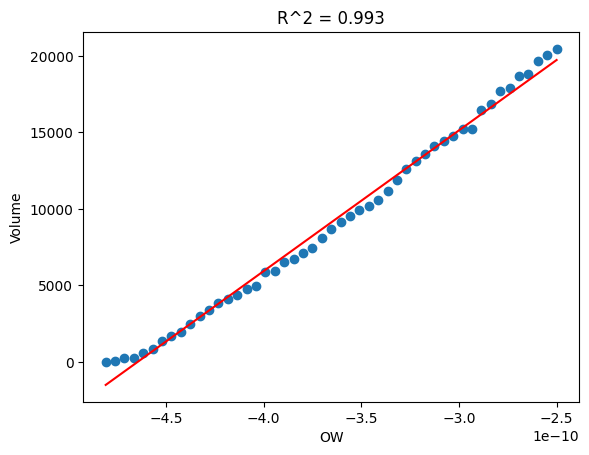

In [9]:
f = C1 + C2 * W

plt.plot(W, f, color='r')
plt.scatter(W, A)
plt.xlabel('OW')
plt.ylabel('Volume')

a = np.sum((A-f)**2)
b = np.sum((A-np.mean(A))**2)

R2 = 1 - a/b

plt.title('R^2 = '+str(round(R2,3))) # We want 90% Confidence

## Petersen2013

(np.float64(156.05976785924366),
 np.float64(157.28276471192618),
 np.float64(-31.618249350989096),
 np.float64(-30.48532190764314))

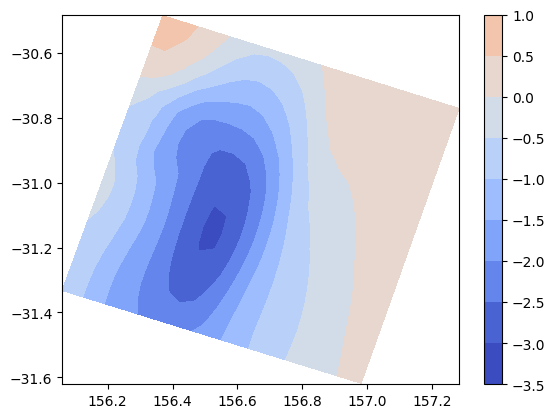

In [10]:
DEPTH_LVL = 15
SEARCH_WIDTH = 100000
i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)
x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)
lon = lon_rho[i_left:i_right, j_down:j_up]
lat = lat_rho[i_left:i_right, j_down:j_up]
u = U[i_left:i_right, j_down:j_up, DEPTH_LVL, t_mod]
v = V[i_left:i_right, j_down:j_up, DEPTH_LVL, t_mod]
ow = OW[i_left:i_right, j_down:j_up, DEPTH_LVL, t_mod]

ocean_mask = np.ones_like(u)

# Apply the mask to OW
OW_mean = np.sum(ow) / np.sum(ocean_mask)

# Calculate the standard deviation
# Compute the squared differences
squared_diffs = (ow - OW_mean)**2

# Apply the ocean_mask and calculate the mean of squared differences
OW_std = np.sqrt(np.sum(ocean_mask * squared_diffs) / np.sum(ocean_mask))

# Normalize OW_raw by OW_std
OW_norm = ow / OW_std

data_range = np.nanmax(np.abs(OW_norm))
plt.contourf(lon, lat, OW_norm, cmap='coolwarm', vmin=-data_range, vmax=data_range)
plt.colorbar()
plt.axis('equal')

### Do the same for full water column

In [11]:
LOW = np.where(LOW_3D!=0, LOW_3D, np.nan)

ocean_mask = np.where(np.isnan(LOW), np.zeros_like(LOW), 1)

# Apply the mask to OW
OW_mean = np.nansum(LOW) / np.sum(ocean_mask)

# Calculate the standard deviation
# Compute the squared differences
squared_diffs = (LOW - OW_mean)**2

# Apply the ocean_mask and calculate the mean of squared differences
OW_std = np.sqrt(np.nansum(ocean_mask * squared_diffs) / np.sum(ocean_mask))

# Normalize OW_raw by OW_std
OW_norm = LOW / OW_std




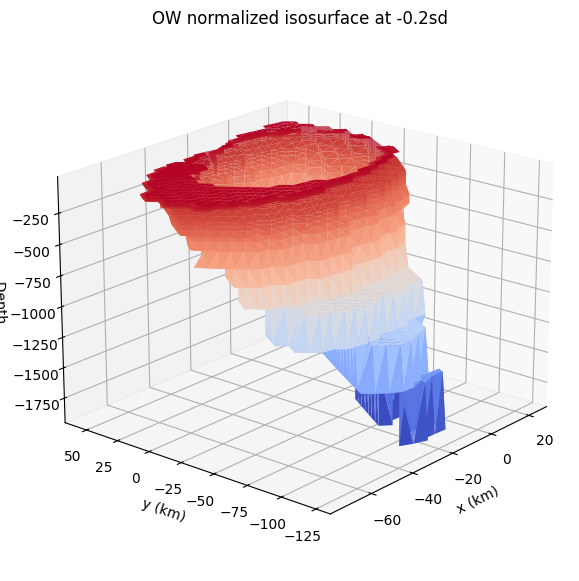

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

OW_norm = np.where(~np.isnan(OW_norm), OW_norm, 0)

# Assuming LOW_3D is already populated as per your code
isosurface_value = -0.2

# Find the isosurface using marching cubes
verts, faces, _, _ = measure.marching_cubes(OW_norm, level=isosurface_value, allow_degenerate=False)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Convert `verts` indices to `lon_rho`, `lat_rho`, and depth `z_r`
lon_vals = lon_rho[verts[:, 0].astype(int), verts[:, 1].astype(int)]
lat_vals = lat_rho[verts[:, 0].astype(int), verts[:, 1].astype(int)]
z_vals = z_r[verts[:, 0].astype(int), verts[:, 1].astype(int), verts[:, 2].astype(int)]

theta0, phi0 = np.deg2rad(edata.Lon), np.deg2rad(edata.Lat)
x, y = make_cartesian(lon_vals, lat_vals, theta0, phi0)

# Plot the isosurface
ax.plot_trisurf(x, y, faces, z_vals, cmap='coolwarm', lw=1)

# Set labels
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('Depth ')

ax.set_title('OW normalized isosurface at -0.2sd')

ax.view_init(elev=20, azim=220)

# Show the plot
plt.show()